In [1]:
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#import data

#flow
sample_data = pd.DataFrame(pd.read_csv('20230505_kw_titer3-Batch_Analysis_19092023154359.csv',delimiter=',', usecols=['Specimen Name','Well Name','FITC %Parent']))

#dilution plates
dilution_data_p1_raw = pd.read_csv('Spike Dilution Plate Scheme.csv')

#which dilutions were used for flow
P1_index_raw = pd.read_csv('Spike (Ace2) Flow Table.csv')


In [3]:
#define sample names
P1_Sample_IDs = dilution_data_p1_raw.columns.tolist()


In [4]:
#Set axis on dilution plates
dilution_data_p1_raw.columns = ['1','2','3','4','5','6','7','8','9','10','11','12']
dilution_data_p1_raw.index = ['A','B','C','D','E','F','G','H']

In [5]:
#combine well position, dilution, and sample names and convert in to a list-like format

dilution_data_p1 = pd.DataFrame(columns=['Dilution Used','Dilution','Sample','Specimen Name'])

for i in dilution_data_p1_raw.index:    
    for x,v in zip(dilution_data_p1_raw.columns,P1_Sample_IDs):
        temp_list = [i+x,dilution_data_p1_raw.loc[i,x],v,'Plate 1']
        dilution_data_p1.loc[len(dilution_data_p1)] = temp_list

In [6]:
dilution_data_p1

,Dilution Used,Dilution,Sample,Specimen Name
0,A1,0.200000,DMSO - 1,Plate 1
1,A2,0.200000,DMSO - 2,Plate 1
2,A3,0.200000,C7 - 1,Plate 1
3,A4,0.200000,C7 - 2,Plate 1
4,A5,0.200000,4µ8c - 1,Plate 1
...,...,...,...,...
91,H8,0.000091,Both - 2,Plate 1
92,H9,NaN,I,Plate 1
93,H10,NaN,J,Plate 1
94,H11,NaN,K,Plate 1


In [7]:
#combine dilution schemes for plate 1 and 2
dilution_data_p1
complete_dilution = pd.concat([dilution_data_p1])

In [8]:
#Set axis on the plates indicating which dilutions were used
P1_index_raw = P1_index_raw.drop(['Unnamed: 0'],axis=1)
P1_index_raw.columns = ['1','2','3','4','5','6','7','8','9','10','11','12']
P1_index_raw.index = ['A','B','C','D','E','F','G','H']


In [9]:
#combine well position, dilution, and sample names and convert in to a list-like format

P1_index = pd.DataFrame(columns=['Well Name','Dilution Used','Specimen Name'])

for i in P1_index_raw.index:
    for x in P1_index_raw.columns:
        temp_list = [i+x, P1_index_raw.loc[i,x],'Plate 1']
        P1_index.loc[len(P1_index)] = temp_list

In [10]:
#combine tables indicatng which dilutions were used for plates 1, 2, and 3
complete_index = pd.concat([P1_index])

In [11]:
#Combine flow data, dilution, and dilution use schemes
merged_sample_data = pd.merge(sample_data,complete_index, on=['Well Name','Specimen Name'], how = 'left')
merged_sample_data = pd.merge(merged_sample_data,complete_dilution, on=['Dilution Used','Specimen Name'], how = 'left')


In [12]:
#Calculate titers using the Poisson formula. 
#If P is the percentage of cells that are ZsGreen positive, then the titer per ml is: -ln(1 − P/100) × (number of cells/well)/(volume of virus per well in mL)
#volume of virus per well well = (150 µL * dilution) = 0.15 mL * dilution

cells_counted = 30375
merged_sample_data['transduction units per mL'] = -np.log(1-(merged_sample_data['FITC %Parent']/100))*(cells_counted/(0.15*merged_sample_data['Dilution']))

In [13]:
#drop samples that had less than 1% or more than 10% FITC stained cells 
filtered_sample_data = merged_sample_data[(merged_sample_data['FITC %Parent'] >= 1) & (merged_sample_data['FITC %Parent'] <= 10)]                                    

In [14]:
filtered_sample_data

,Specimen Name,Well Name,FITC %Parent,Dilution Used,Dilution,Sample,transduction units per mL
0,Plate 1,A1,7.7,C1,0.022222,DMSO - 1,7.301493e+05
1,Plate 1,A2,8.1,D2,0.007407,DMSO - 2,2.309178e+06
2,Plate 1,A3,4.6,C3,0.022222,C7 - 1,4.291227e+05
3,Plate 1,A4,3.0,C4,0.022222,C7 - 2,2.775598e+05
4,Plate 1,A5,3.3,C5,0.022222,4µ8c - 1,3.057865e+05
...,...,...,...,...,...,...,...
123,Plate 2,G4,1.5,NaN,NaN,NaN,NaN
124,Plate 2,G5,1.6,NaN,NaN,NaN,NaN
125,Plate 2,G6,1.1,NaN,NaN,NaN,NaN
126,Plate 2,G7,1.1,NaN,NaN,NaN,NaN


In [15]:
#Add a column to indicate if spike production was induced (true) or vsvg (false)

filtered_sample_data['induction'] = filtered_sample_data['Specimen Name'] == "Plate 1"


/var/folders/sv/w2n5lcb57zz70hk1l6tkkkf00000gp/T/ipykernel_4981/2889561959.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_sample_data['induction'] = filtered_sample_data['Specimen Name'] == "Plate 1"


In [16]:
filtered_sample_data

,Specimen Name,Well Name,FITC %Parent,Dilution Used,Dilution,Sample,transduction units per mL,induction
0,Plate 1,A1,7.7,C1,0.022222,DMSO - 1,7.301493e+05,True
1,Plate 1,A2,8.1,D2,0.007407,DMSO - 2,2.309178e+06,True
2,Plate 1,A3,4.6,C3,0.022222,C7 - 1,4.291227e+05,True
3,Plate 1,A4,3.0,C4,0.022222,C7 - 2,2.775598e+05,True
4,Plate 1,A5,3.3,C5,0.022222,4µ8c - 1,3.057865e+05,True
...,...,...,...,...,...,...,...,...
123,Plate 2,G4,1.5,NaN,NaN,NaN,NaN,False
124,Plate 2,G5,1.6,NaN,NaN,NaN,NaN,False
125,Plate 2,G6,1.1,NaN,NaN,NaN,NaN,False
126,Plate 2,G7,1.1,NaN,NaN,NaN,NaN,False


In [17]:
#Calculate mean and SEM for each sample
mean = (filtered_sample_data.groupby(['Sample','induction'], as_index=False)['transduction units per mL'].mean()).rename(columns={'transduction units per mL': 'Mean transduction units per mL'})
std = (filtered_sample_data.groupby(['Sample','induction'], as_index=False)['transduction units per mL'].std()).rename(columns={'transduction units per mL': "std"})

merged = mean.merge(std, on = ['Sample', 'induction'])

In [18]:
#sorting list
merged = merged.sort_values(by='induction')
merged

,Sample,induction,Mean transduction units per mL,std
0,4µ8c - 1,True,2.869784e+05,26598.663104
1,4µ8c - 2,True,1.655241e+05,13123.257056
2,Both - 1,True,1.608819e+05,6558.287576
3,Both - 2,True,1.007930e+05,NaN
4,C7 - 1,True,3.746048e+05,52767.830388
5,C7 - 2,True,2.401366e+05,52924.461701
6,DMSO - 1,True,6.618164e+05,93042.850065
7,DMSO - 2,True,2.031000e+06,289950.849548


In [19]:
merged

,Sample,induction,Mean transduction units per mL,std
0,4µ8c - 1,True,2.869784e+05,26598.663104
1,4µ8c - 2,True,1.655241e+05,13123.257056
2,Both - 1,True,1.608819e+05,6558.287576
3,Both - 2,True,1.007930e+05,NaN
4,C7 - 1,True,3.746048e+05,52767.830388
5,C7 - 2,True,2.401366e+05,52924.461701
6,DMSO - 1,True,6.618164e+05,93042.850065
7,DMSO - 2,True,2.031000e+06,289950.849548


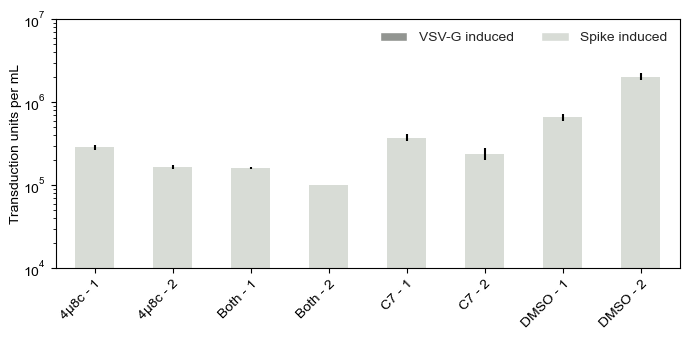

In [20]:
#import some extra plotting functions
from matplotlib.patches import Patch
import matplotlib as mpl
import matplotlib.lines as lines
import matplotlib.colors as mcolors

#define some stuff for plotting
axes_titles = merged.Sample.unique().tolist() #set sample names for plot
x_len = np.arange(len(axes_titles)) #generate an iterable for # of samples
bar_width = 0.2

# Create subplots
#pick some colors
VSV_color = '#929591'
spike_color = '#d8dcd6'

#prepare std for plotting
merged['plot_std'] = merged['std'] * np.log(2)

# Set figure size
fig, ax = plt.subplots(figsize=(7, 3.5))  # Adjust the dimensions as desired

# Plot bar chart
merged.plot(kind='bar', x='Sample', y='Mean transduction units per mL', yerr='plot_std', color=merged['induction'].map({True: spike_color, False: VSV_color}), legend=False, ax=ax)
ax.set_yscale('log')
plt.ylim(1e4, 1e7)
sns.set_style("ticks")

# Set labels and title
plt.xlabel('')
plt.ylabel('Transduction units per mL', labelpad=0.5, fontsize=10)
plt.yticks(fontsize=10)
plt.title('')
plt.xticks(fontsize=10, rotation=45, ha='right', rotation_mode="anchor")

legend_elements = [Patch(facecolor=VSV_color, label='VSV-G induced'),
                   Patch(facecolor=spike_color, label='Spike induced')]
plt.legend(handles=legend_elements, fontsize=10, loc='upper right', ncol=4, frameon=False)

# Show the plot
plt.tight_layout()
#plt.savefig('titering Ace2.pdf')

In [21]:
merged

,Sample,induction,Mean transduction units per mL,std,plot_std
0,4µ8c - 1,True,2.869784e+05,26598.663104,18436.788337
1,4µ8c - 2,True,1.655241e+05,13123.257056,9096.348628
2,Both - 1,True,1.608819e+05,6558.287576,4545.858543
3,Both - 2,True,1.007930e+05,NaN,NaN
4,C7 - 1,True,3.746048e+05,52767.830388,36575.872858
5,C7 - 2,True,2.401366e+05,52924.461701,36684.441411
6,DMSO - 1,True,6.618164e+05,93042.850065,64492.389194
7,DMSO - 2,True,2.031000e+06,289950.849548,200978.613865
